![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [1]:
# Libs
import pandas as pd
import numpy as np

# reading the file and checking for NAs
df = pd.read_csv('rental_info.csv')

print(df.isna().sum().sort_values())
print('*'*30)
print(df.dtypes)
print('*'*30)

# creating length feature
df['rental_date'] = pd.to_datetime(df['rental_date'])
df['return_date'] = pd.to_datetime(df['return_date'])
df['rental_length_days'] = (df['return_date']-df['rental_date']).dt.days

# creating a dummy format for "special_features"
df['deleted_scenes'] = df['special_features'].str.contains("Deleted Scenes").astype('int')
df['behind_the_scenes'] = df['special_features'].str.contains("Behind the Scenes").astype('int')

df.head()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64
******************************
rental_date          object
return_date          object
amount              float64
release_year        float64
rental_rate         float64
length              float64
replacement_cost    float64
special_features     object
NC-17                 int64
PG                    int64
PG-13                 int64
R                     int64
amount_2            float64
length_2            float64
rental_rate_2       float64
dtype: object
******************************


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


In [2]:
# Libs
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
# creating the datasets
X = df.drop(['special_features','rental_length_days','rental_date','return_date'], axis = 1)
y = df['rental_length_days']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=.2, 
    random_state=9, 
    stratify=y
)

# making a scaler to use polynomial variables
scaler = StandardScaler()

# making KFold for all models cross-validation 
kfold = KFold(n_splits=10, random_state=9, shuffle=True)



(15861, 14)
******************************


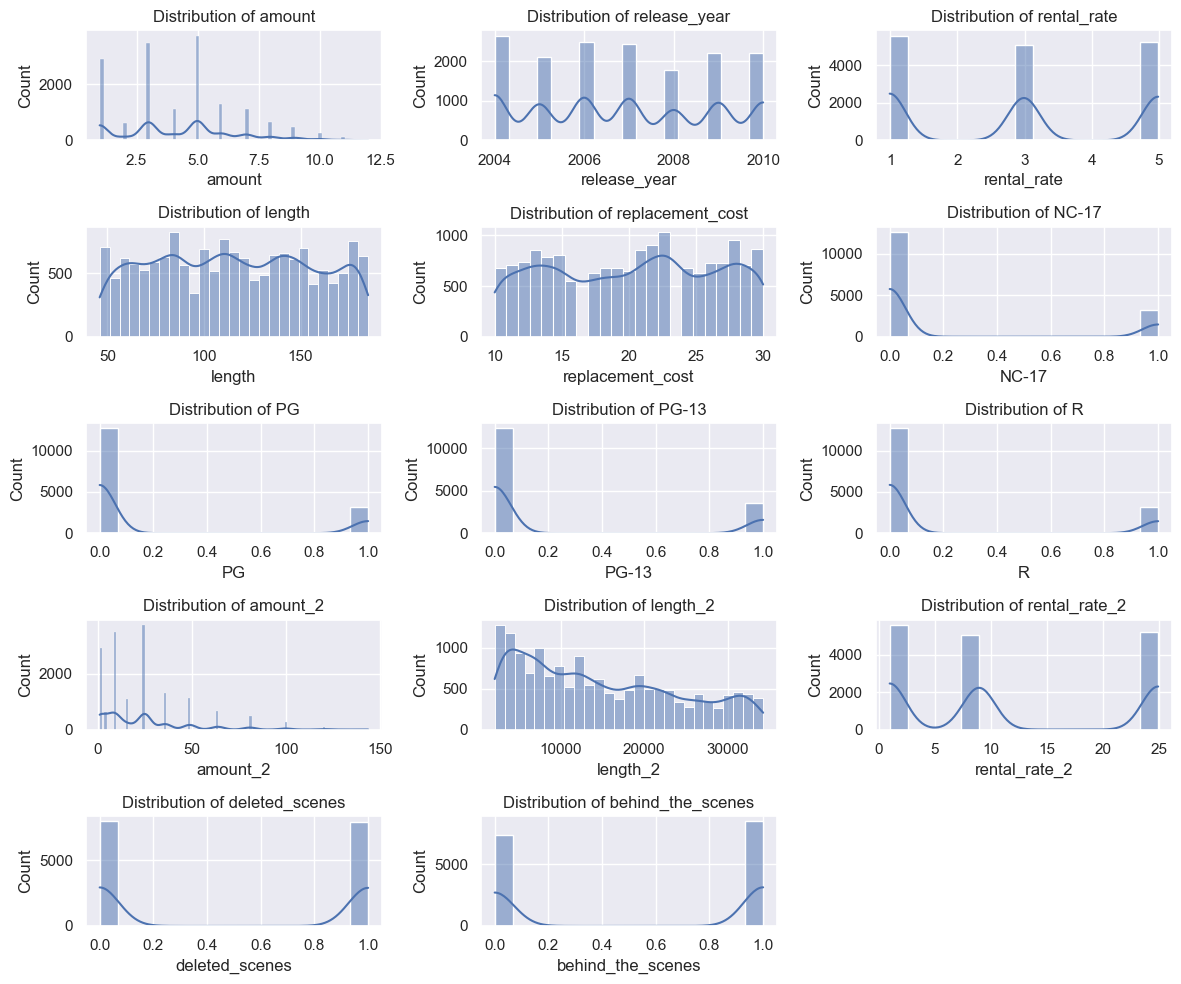

In [3]:
# looking at the data
print(X.shape)
print('*'*30)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(12,10)})

fig, axes = plt.subplots(5, 3)
axes = axes.ravel()
for i, col in enumerate(X.columns):
    sns.histplot(X[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')

plt.delaxes(axes[14])
plt.tight_layout()
plt.show()

In [4]:
## Ridge model with hyperparameter tuning
# Libs
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

# creating the pipeline
ridge_reg = Ridge()
pipe_reg = make_pipeline(
    scaler, 
    ridge_reg
)

# hyperparameter tuning for Ridge (only alpha)
params_ridge = {'ridge__alpha':np.arange(0,40,2)}
ridge_cv = RandomizedSearchCV(
    pipe_reg, 
    param_distributions=params_ridge, 
    random_state=9, 
    cv=kfold,
    n_iter=20
)

# fit_predict and results for Ridge
cv_ridge_result = ridge_cv.fit(X_train, y_train)
y_pred_ridge = cv_ridge_result.predict(X_test)

print(f"train_score:{cv_ridge_result.best_score_}")
print(f"test_score:{cv_ridge_result.score(X_test, y_test)}")

print(f"MSE is {MSE(y_test, y_pred_ridge)}")

train_score:0.5867956554521967
test_score:0.5859718709661765
MSE is 2.874977484385879


In [5]:
# using adaptive boosting
# Libs
from sklearn.ensemble import AdaBoostRegressor

# creating the pipeline
ada_reg = AdaBoostRegressor()
ada_pipe = make_pipeline(
    scaler, 
    ada_reg
)

# hyperparameter tuning for AdaBoost 
params_ada = {
    'adaboostregressor__learning_rate':np.arange(0.01,.95, .1),
    'adaboostregressor__n_estimators':np.arange(50,200,10),
}
ada_cv = RandomizedSearchCV(
    ada_pipe, 
    param_distributions=params_ada, 
    random_state=9, 
    cv=kfold,
    n_iter=20
)

# fit_predict and results for Ridge
cv_ada_result = ada_cv.fit(X_train, y_train)
y_pred_ada = cv_ada_result.predict(X_test)

print(f"train_score:{cv_ada_result.best_score_}")
print(f"test_score:{cv_ada_result.score(X_test, y_test)}")

print(f"MSE is {MSE(y_test, y_pred_ada)}")


train_score:0.6038161795147337
test_score:0.5597862112765662
MSE is 3.0568085647936307


In [6]:
## RandomForest with hyperparameter tuning
#Libs
from sklearn.ensemble import RandomForestRegressor

# creating pipeline
ranf_reg = RandomForestRegressor()
ranf_pipe = make_pipeline(
    scaler,
    ranf_reg
)

# hyperparameter tuning for ranf (max_depth, min_samples_leaf, n_estimator)
params_ranf = {
    'randomforestregressor__max_depth':np.arange(1,10,1),
    'randomforestregressor__min_samples_leaf':np.arange(.01,.4,.05),
    'randomforestregressor__n_estimators':np.arange(100,210,10)
}
ranf_cv = RandomizedSearchCV(
    ranf_pipe,
    param_distributions=params_ranf,
    random_state=9,
    cv=kfold,
    n_iter=20
)

# fit_predict and results for ranf_reg
ranf_cv_result = ranf_cv.fit(X_train, y_train)
y_pred_ranf = ranf_cv_result.predict(X_test)

print(f"train_score:{ranf_cv_result.best_score_}")
print(f"test_score:{ranf_cv_result.score(X_test, y_test)}")

print(f"MSE is {MSE(y_test, y_pred_ranf)}")

train_score:0.6533137448425069
test_score:0.6562285242578105
MSE is 2.3871210268714864


In [7]:
## stochastic gradient boosting 
# Libs
from sklearn.ensemble import GradientBoostingRegressor

# create a pipeline 
grad_reg = GradientBoostingRegressor()
grad_pipe = make_pipeline(
    scaler,
    grad_reg
)

# hyperparameter tuning for gradient boosting
params_grad = {
    'gradientboostingregressor__max_depth':np.arange(1,10,1),
    'gradientboostingregressor__max_depth__min_samples_leaf':np.arange(.01,.4,.05),
    'gradientboostingregressor__max_depth__n_estimators':np.arange(100,210,10),
    'gradientboostingregressor__subsample':np.arange(.1,.9,.1),
    'gradientboostingregressor__max_features':np.arange(.5,1,.1)
}
grad_cv = RandomizedSearchCV(
    grad_pipe,
    param_distributions=params_grad,
    random_state=9,
    cv=kfold,
    n_iter=20
)

# fit_predict and results for grad_reg
grad_cv_result = ranf_cv.fit(X_train, y_train)
y_pred_grad = grad_cv_result.predict(X_test)

print(f"train_score:{grad_cv_result.best_score_}")
print(f"test_score:{grad_cv_result.score(X_test, y_test)}")

print(f"MSE is {MSE(y_test, y_pred_grad)}")

train_score:0.6533754664814444
test_score:0.6562561085373915
MSE is 2.386929483888879


In [8]:
best_model = ranf_cv_result.best_estimator_
best_mse = MSE(y_test, y_pred_ranf)
print(f"The best model and its features: {best_model.named_steps['randomforestregressor']}")
print(f"best MSE achieved is: {best_mse}")

The best model and its features: RandomForestRegressor(max_depth=9, min_samples_leaf=0.01, n_estimators=150)
best MSE achieved is: 2.3871210268714864
